In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
# import itertools

from matplotlib.lines import Line2D
import matplotlib.cm  as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec

In [6]:
river_sources = np.load('../river_sources.npy', allow_pickle=True).item()
river_sources.pop('Itajai')

(-26.9125, -48.5)

In [7]:
time_range = pd.date_range('2018-01-01 12:00:00', '2019-10-23 12:00', freq='1d')

# animation

In [8]:
river_sources.keys()

dict_keys(['Luanda', 'Cuvo', 'Paraiba', 'Chiloango-Congo', 'Cape-Town', 'Rio-de-la-Plata', 'Rio-de-Janeiro', 'Porto-Alegre', 'Santos'])

In [ ]:
simulations = {}

for loc in river_sources.keys():
    simulations[loc] = xr.load_dataset(f"../data/simulations/sa-s03/sa-S03_{loc}.nc")

In [15]:
true_labels = ['Luanda', 'Cuvo river', 'Paraiba do Sul', 'Chiloango-Congo', 'Cape-Town', 'Rio-de-la-Plata', 'Rio-de-Janeiro', 'Porto-Alegre', 'Santos']

In [ ]:
fig,ax = plt.subplots(figsize=(10,7),
                      subplot_kw={'projection': ccrs.PlateCarree()})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
# gl.right_labels = False

t = 660
ax.set_extent([-73.0, 24.916666,-60.916664, -5], crs=ccrs.PlateCarree())

#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.COASTLINE)

ax.add_feature(cfeature.BORDERS, linestyle=':')

x_colors = np.linspace(0,1, 10)
colors = cm.get_cmap('tab10')(x_colors)

for j, loc in enumerate(river_sources.keys()):
    
    scatter = ax.scatter(simulations[loc]['lon'].values[:, t],
                         simulations[loc]['lat'].values[:, t],
                     s=0.1, color=colors[j], alpha=0.4)
    
legend_elements = [Line2D([0], [0], marker='o', color='w',
                          label=loc, markersize=7,
                          markerfacecolor=colors[j]) for j,loc in enumerate(true_labels)]

ax.legend(handles=legend_elements, loc='upper left')# bbox_to_anchor=(1.02, 1))
# date_str = str(date_range[t].date())
title = ax.set_title(f'Particle age = {t} days')

In [22]:
%%capture

fig,ax = plt.subplots(figsize=(10,6.5),
                      subplot_kw={'projection': ccrs.PlateCarree()})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
# gl.right_labels = False

t = 300
ax.set_extent([-73.0, 24.916666,-60.916664, -5], crs=ccrs.PlateCarree())

#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

ax.add_feature(cfeature.BORDERS, linestyle=':')

x_colors = np.linspace(0,1, 10)
colors = cm.get_cmap('tab10')(x_colors)
handles = []

for j, loc in enumerate(river_sources.keys()):
    
    scatter = ax.scatter(simulations[loc]['lon'].values[:, 0],
                         simulations[loc]['lat'].values[:, 0],
                     s=0.1, color=colors[j], alpha=0.4)
    handles.append(scatter)
    
legend_elements = [Line2D([0], [0], marker='o', color='w',
                          label=loc, markersize=7,
                          markerfacecolor=colors[j]) for j,loc in enumerate(true_labels)]

ax.legend(handles=legend_elements, loc='upper left')

# date_str = str(date_range[t].date())
title = ax.set_title(f'Particle age = {0} days')

def animate_age(i):
    title.set_text(f'Particle age = {i} days')
    
    for j, loc in enumerate(river_sources.keys()):
        handles[j].set_offsets(np.c_[simulations[loc]['lon'].values[:, i],
                                     simulations[loc]['lat'].values[:, i]])
    
    
anim_age = FuncAnimation(fig, animate_age, frames = 660, interval=500)

In [23]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Claudio'), bitrate=3000)

In [24]:
anim_age.save('../presentation/images/smoc_animation.mp4', writer=writer, dpi=100)

# Nioz sampling points

In [25]:
nioz = np.load('../data/NIOZ_sampling_locations.pkl', allow_pickle=True)

In [26]:
nioz = pd.DataFrame(nioz)

In [27]:
nioz.head()

,date,latitude,longitude
0,2019-01-04,-33.66477,18.03866
1,2019-01-05,-33.51575,15.40349
2,2019-01-05,-33.43135,13.62885
3,2019-01-06,-33.31850,11.47783
4,2019-01-07,-32.67499,7.03407


In [28]:
def getclosest_ij(lats,lons,latpt,lonpt):    
    """Function to find the index of the closest point to a certain lon/lat value."""
    dist_lat = (lats-latpt)**2                      # find squared distance of every point on grid
    dist_lon = (lons-lonpt)**2
    minindex_lat = dist_lat.argmin()                # 1D index of minimum dist_sq element
    minindex_lon = dist_lon.argmin()
    return minindex_lon, minindex_lat 

In [33]:
nioz_prob = {}
maxlabels = []

for j,loc in enumerate(river_sources.keys()):
    temp_prob = np.zeros(len(nioz))
    
    for i in range(len(nioz)):
        lats = params['lat_range']
        lons = params['lon_range']
        lat_sample = nioz.loc[i]['latitude']
        lon_sample = nioz.loc[i]['longitude']

        idx = getclosest_ij(lats, lons, lat_sample, lon_sample)
        temp_prob[i] = post_avg[loc][0, idx[0], idx[1]]
    nioz_prob[loc] = temp_prob

In [35]:
# nioz_prob = {}
maxlabels = []


for i in range(len(nioz)):
    
    temp_prob = np.zeros(len(nioz))
    lats = params['lat_range']
    lons = params['lon_range']
    lat_sample = nioz.loc[i]['latitude']
    lon_sample = nioz.loc[i]['longitude']

    idx = getclosest_ij(lats, lons, lat_sample, lon_sample)
    
    sample_proba = np.zeros(9)
    max_prob = 0
    max_label = ''
    for j,loc in enumerate(river_sources.keys()):
        
        sample_proba = post_avg[loc][0, idx[0], idx[1]]
        if sample_proba > max_prob:
            max_prob = sample_proba
            max_label = loc
            
    maxlabels.append((max_label, max_prob))
    

In [36]:
maxlabels

[('Cape-Town', 0.9999920248804524),
 ('Cape-Town', 0.8610514674975923),
 ('Rio-de-la-Plata', 0.5057744407697938),
 ('Cape-Town', 0.8909702942108407),
 ('Rio-de-la-Plata', 0.46110719244446713),
 ('Cape-Town', 0.615713367270198),
 ('Cape-Town', 0.8879271021333793),
 ('Cape-Town', 0.5847613775547613),
 ('Rio-de-la-Plata', 0.4589609098228001),
 ('Rio-de-la-Plata', 0.4683081819062314),
 ('Cape-Town', 0.3653978507305133),
 ('Rio-de-la-Plata', 0.5445541727278996),
 ('Rio-de-la-Plata', 0.4283098886219917),
 ('Rio-de-la-Plata', 0.5288717099244375),
 ('Cape-Town', 0.6766354167335666),
 ('Cape-Town', 0.4917641411664862),
 ('Cape-Town', 0.6167904122595268),
 ('Cape-Town', 0.683218067539537),
 ('Cape-Town', 0.7239491758259755),
 ('Cape-Town', 0.6581432007511022),
 ('Cape-Town', 0.8375441883062437),
 ('Rio-de-la-Plata', 0.5341589404917462),
 ('Cape-Town', 0.5828244607362927),
 ('Cape-Town', 0.9866547852734127)]

In [37]:
river_sources.keys()

dict_keys(['Luanda', 'Cuvo', 'Paraiba', 'Chiloango-Congo', 'Cape-Town', 'Rio-de-la-Plata', 'Rio-de-Janeiro', 'Porto-Alegre', 'Santos'])

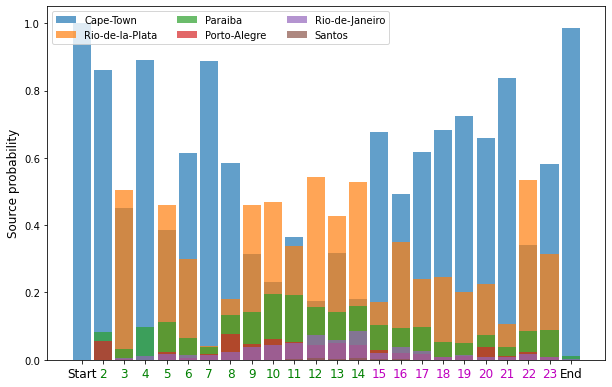

In [38]:
X = np.linspace(1,24, 24, dtype=int)

width = 0.85      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(10,6.5))
poto = 0

arranged_sources = ['Cape-Town', 'Rio-de-la-Plata','Paraiba', 'Porto-Alegre', 'Rio-de-Janeiro','Santos']

for loc in arranged_sources:
    
    ax.bar(X, nioz_prob[loc], width, label=loc, bottom=poto, alpha=0.7, zorder=1)
    poto =0#+= nioz_prob[loc]

ax.set_ylabel('Source probability', fontsize=12)
ax.set_title('')
ax.legend(loc='upper left', ncol=3)
a = ['Start'] + [i+1 for i in range(1, 23)] + ['End']
ax.set_xticks(X)
ax.set_xticklabels(a, fontsize=12)
my_colors = ['k']+['g']*13 + ['m']*9 + ['k']

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
    
plt.savefig('../presentation/images/nioz_source_proba_hist.png', dpi=140, facecolor=(1,0,0,0))

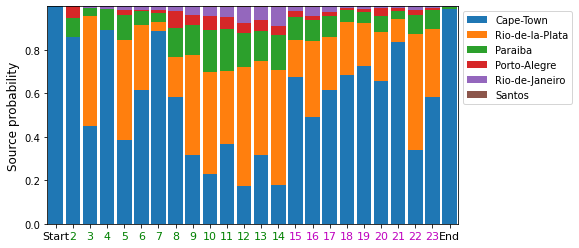

In [39]:
X = np.linspace(1,24, 24, dtype=int)
width = 0.85      
poto = 0

fig = plt.figure(figsize=(9, 4))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, width_ratios=(9,1))


arranged_sources = ['Cape-Town', 'Rio-de-la-Plata','Paraiba', 'Porto-Alegre', 'Rio-de-Janeiro','Santos']

ax = fig.add_subplot(spec[0, 0])


for loc in arranged_sources:
    
    ax.bar(X, nioz_prob[loc], width, label=loc, bottom=poto)
    poto += nioz_prob[loc]

ax.set_ylabel('Source probability', fontsize=12)
ax.set_title('')
ax.legend(loc='upper left', bbox_to_anchor=(1., 1))
ax.set_xticks(X)


ax.set_xlim(0.5,24.5)


a = ['Start'] + [i+1 for i in range(1, 23)] + ['End']

ax.set_xticklabels(a, fontsize=11)
my_colors = ['k']+['g']*13 + ['m']*9 + ['k']

# ax.set_xticklabels(b, fontsize=11)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)

# ax_top = ax.twiny()
# ax_top.set_xticks(X)
# ax_top.set_xlim(0.5,24.5)
# ax_top.set_xticklabels(b, fontsize=9)

ax2 = fig.add_subplot(spec[0, 1])
ax2.axis('off')
plt.savefig('../presentation/images/nioz_source_proba_bar.png', dpi=140, facecolor=(1,0,0,0))

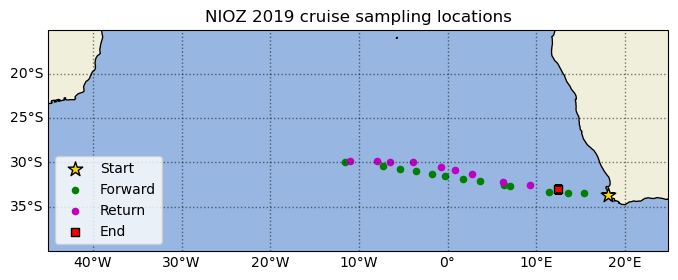

In [459]:
y,x = np.meshgrid(params['lat_range'], params['lon_range'])

fig,ax = plt.subplots(figsize=(8,5),
                      subplot_kw={'projection': ccrs.PlateCarree()})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-45.0, 24.916666,-40., -15.0833335], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.COASTLINE)


ax.scatter(nioz['longitude'][0], nioz['latitude'][0], 
               s=120, marker='*', edgecolor='k', color='gold', label = 'Start', zorder=3)

ax.scatter(nioz['longitude'][:14], nioz['latitude'][:14], 
               s=20, marker='o', color='green', label = 'Forward')

ax.scatter(nioz['longitude'][14:-1], nioz['latitude'][14:-1], 
               s=20, marker='o', color='m', label = 'Return')

ax.scatter(nioz['longitude'][23], nioz['latitude'][23], 
               s=30, marker='s', color='red', edgecolor='k', label = 'End')

plt.legend(loc='lower left')
ax.set_title('NIOZ 2019 cruise sampling locations')
plt.savefig('../presentation/images/nioz_sampling_sites.png', dpi=140, facecolor=(1,0,0,0))

In [192]:
idx[1], idx[0]

(104, 56)

In [191]:
post_avg['Rio-de-la-Plata'][20, idx[1], idx[0]]

0.0

In [168]:
post_avg['Rio-de-Janeiro'][20,60,50]

0.1802904403821783

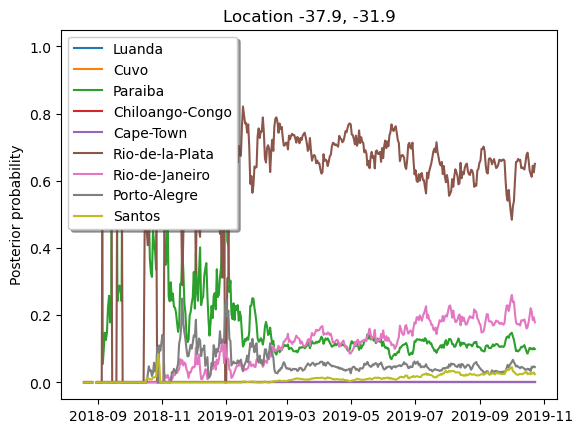

In [41]:
i_lon = 60
i_lat = 50
lat = params['lat_range'][i_lat]
lon = params['lon_range'][i_lat]

for loc in labels:
    plt.plot(time_range, posterior[loc][:, i_lon, i_lat], label=loc)
    #plt.plot(time_range, posterior['Rio-de-la-Plata'][:, i_lon, i_lat], label='La Plata', c='k')
plt.ylabel('Posterior probability')
plt.title(f'Location {lat:0.1f}, {lon:0.1f}')
plt.legend(shadow=True)


In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

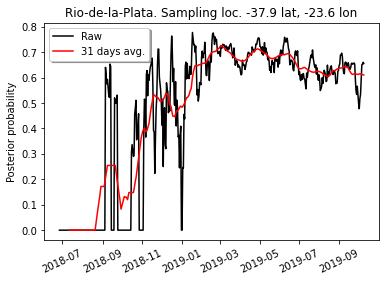

In [13]:
i_lon = 60
i_lat = 50
lat = params['lat_range'][i_lat]
lon = params['lon_range'][i_lon]
window = 31
loc = 'Rio-de-la-Plata'

og = posterior[loc][:, i_lon, i_lat]
avg = moving_average(posterior[loc][:, i_lon, i_lat], window)
index_slice = int((window-1)/2)
w_slice = slice(index_slice, -index_slice)

plt.plot(time_range[w_slice], og[w_slice], label='Raw', c='k')
plt.plot(time_range[w_slice], avg, label=f'{window} days avg.', c='r')
plt.xticks(rotation = 25)
plt.ylabel('Posterior probability')
plt.title(f'{loc}. Sampling loc. {lat:0.1f} lat, {lon:0.1f} lon')
plt.legend(shadow=True, )


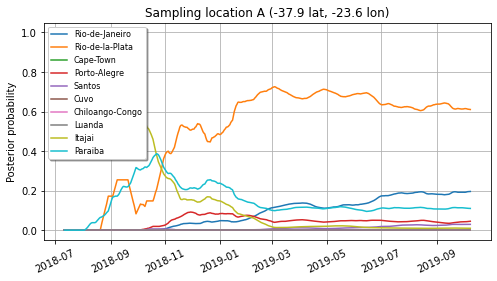

In [14]:
i_lon = 60
i_lat = 50
lat = params['lat_range'][i_lat]
lon = params['lon_range'][i_lon]
window = 31
index_slice = int((window-1)/2)
w_slice = slice(index_slice, -index_slice)

plt.figure(figsize=(8,4))
for loc in labels:
    avg = moving_average(posterior[loc][:, i_lon, i_lat], window)
    plt.plot(time_range[w_slice], avg, label=loc)

plt.xticks(rotation = 25)
plt.ylabel('Posterior probability')
plt.title(f'Sampling location A ({lat:0.1f} lat, {lon:0.1f} lon)')
plt.legend(shadow=True, fontsize=8, loc='upper left')
plt.grid()

In [15]:
params['lon_range'].shape

(120,)

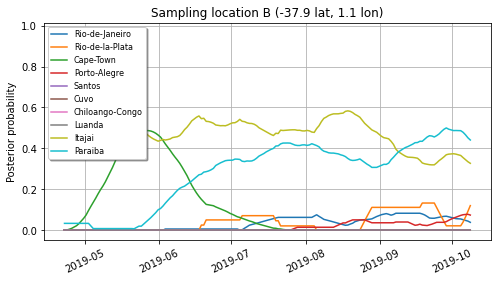

In [16]:
i_lon = 90
i_lat = 50
lat = params['lat_range'][i_lat]
lon = params['lon_range'][i_lon]
window = 31
index_slice = int((window-1)/2)
w_slice = slice(index_slice, -index_slice)

plt.figure(figsize=(8,4))
for loc in labels:
    avg = moving_average(posterior[loc][:, i_lon, i_lat], window)
    plt.plot(time_range[w_slice], avg, label=loc)

plt.xticks(rotation = 25)
plt.ylabel('Posterior probability')
plt.title(f'Sampling location B ({lat:0.1f} lat, {lon:0.1f} lon)')
plt.legend(shadow=True, fontsize=8, loc='upper left')
plt.grid()

Text(0.5, 1.0, 'Sampling location')

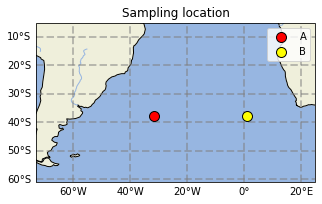

In [17]:
y,x = np.meshgrid(params['lat_range'], params['lon_range'])

fig,ax = plt.subplots(figsize=(5,5),
                      subplot_kw={'projection': ccrs.PlateCarree()})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

loc = 'Rio-de-la-Plata'
t =660
ax.set_extent([-73.0, 24.916666,-60.916664, -5.0833335], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
    
#im = ax.pcolormesh(x,y,posterior[loc][t],cmap='viridis')
ax.scatter(params['lon_range'][50], params['lat_range'][i_lat], 
               s=100, marker='o', color='red', edgecolors='k', zorder=3, label = 'A')

ax.scatter(params['lon_range'][90], params['lat_range'][i_lat], 
               s=100, marker='o', color='yellow', edgecolors='k', zorder=3, label = 'B')


plt.legend()
ax.set_title('Sampling location')